In [1]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets
from torchvision import transforms

In [2]:
data_dir = '../data/gray_formatted/'
batch_size = 16
n_workers = 4
n_epochs = 1000
lr = 0.001
img_dim = 64
display_delay = 999999
disc_noise_chance = 0.025
label_noise = 0 # 0.05

# Generator params
ds_kernels = [7, 3, 3, 3, 3]
ds_filters = [32, 64, 64, 128, 128]

n_res_blocks = 6
res_kernel = 3
res_filter = ds_filters[-1]

us_kernels = [3, 3, 3, 3, 7]
us_filters = [64, 64, 32, 32, 1]

# Discriminator params
disc_kernels = [3, 3, 3, 3, 3, 3, 3]
disc_filters = [16, 32, 64, 64, 128, 128, 1]
disc_strides = [1, 2, 1, 2, 1, 1, 1]

In [3]:
def input_transform(img):
    img = np.array(img)[:, :, 0]
    target, outline = np.split(img, 2, axis=1)
    target = transforms.ToTensor()(target)
    outline = transforms.ToTensor()(outline)
    return outline, target

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
datasets = {k: torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, k), transform=input_transform) \
    for k in os.listdir(data_dir)}

# Create the dataloader
dataloaders = {k: torch.utils.data.DataLoader(v, batch_size=batch_size,
    shuffle=True, num_workers=0)
    for k, v in datasets.items()}

def get_generator(partition):
    for (X, y), _ in dataloaders[partition]:
        yield X, y

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # 1 x 64 x 64 input
        self.in_filters = 1

        ### Downscale ###

        self.ds1 = nn.Sequential(
            nn.Conv2d(self.in_filters, ds_filters[0], kernel_size=ds_kernels[0],
                      stride=1, padding=(ds_kernels[0]-1)//2),
            nn.BatchNorm2d(ds_filters[0]),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(ds_filters[0], ds_filters[1], kernel_size=ds_kernels[1],
                      stride=2, padding=(ds_kernels[1]-1)//2),
            nn.Conv2d(ds_filters[1], ds_filters[2], kernel_size=ds_kernels[2],
                      stride=1, padding=(ds_kernels[2]-1)//2),
            nn.BatchNorm2d(ds_filters[2]),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(ds_filters[2], ds_filters[3], kernel_size=ds_kernels[3],
                      stride=2, padding=(ds_kernels[3]-1)//2),
            nn.Conv2d(ds_filters[3], ds_filters[4], kernel_size=ds_kernels[4],
                      stride=1, padding=(ds_kernels[4]-1)//2),
            nn.BatchNorm2d(ds_filters[4]),
            nn.ReLU(),
            nn.Dropout(0.4))
        
        ### Residual blocks ###

        self.res_blocks = []
        for _ in range(n_res_blocks):
            res_block = nn.Sequential(
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.BatchNorm2d(res_filter),
                nn.ReLU(),
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.Dropout(0.2))

            self.res_blocks.append(res_block)
            
        ### Upscale ###
            
        self.us1 = nn.Sequential(
            nn.Conv2d(res_filter, us_filters[0], kernel_size=us_kernels[0],
                      stride=1, padding=(us_kernels[0]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[0], us_filters[1], kernel_size=us_kernels[1],
                      stride=1, padding=(us_kernels[1]-1)//2),
            nn.BatchNorm2d(us_filters[1]),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(us_filters[1], us_filters[2], kernel_size=us_kernels[2],
                      stride=1, padding=(us_kernels[2]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[2], us_filters[3], kernel_size=us_kernels[3],
                      stride=1, padding=(us_kernels[3]-1)//2),
            nn.BatchNorm2d(us_filters[3]),
            nn.ReLU())
        self.us3 = nn.Conv2d(us_filters[3], us_filters[4], kernel_size=us_kernels[4],
            stride=1, padding=(us_kernels[4]-1)//2)
        
    def forward(self, x):
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z = z3
        for i in range(len(self.res_blocks)):
            res_output = self.res_blocks[i](z)
            z = z + res_output
        
        z4 = self.us1(z)
        z5 = self.us2(z4)
        raw = self.us3(z5)
        out = torch.clamp(raw, 0, 1)
    
        return out

    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        for res_block in self.res_blocks:
            res_block = res_block.to(*args, **kwargs) 
        return self

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 2 x 64 x 64 input
        self.in_filters = 2

        ### Downscale ###

        self.layer1 = nn.Sequential(
            nn.Conv2d(self.in_filters, disc_filters[0], kernel_size=disc_kernels[0],
                      stride=disc_strides[0], padding=(disc_kernels[0]-1)//2),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(disc_filters[0], disc_filters[1], kernel_size=disc_kernels[1],
                      stride=disc_strides[1], padding=(disc_kernels[1]-1)//2),
            nn.LeakyReLU(),
            nn.Conv2d(disc_filters[1], disc_filters[2], kernel_size=disc_kernels[2],
                      stride=disc_strides[2], padding=(disc_kernels[2]-1)//2),
            nn.BatchNorm2d(disc_filters[2]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer3 = nn.Sequential(
            nn.Conv2d(disc_filters[2], disc_filters[3], kernel_size=disc_kernels[3],
                      stride=disc_strides[3], padding=(disc_kernels[3]-1)//2),
            nn.LeakyReLU(),
            nn.Conv2d(disc_filters[3], disc_filters[4], kernel_size=disc_kernels[4],
                      stride=disc_strides[4], padding=(disc_kernels[4]-1)//2),
            nn.BatchNorm2d(disc_filters[4]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer4 = nn.Sequential(
            nn.Conv2d(disc_filters[4], disc_filters[5], kernel_size=disc_kernels[5],
                      stride=disc_strides[5], padding=(disc_kernels[5]-1)//2),
            nn.BatchNorm2d(disc_filters[5]),
            nn.LeakyReLU(),
            nn.Dropout(0.4))
        self.layer5 = nn.Conv2d(disc_filters[5], disc_filters[6], kernel_size=disc_kernels[6],
            stride=disc_strides[6], padding=(disc_kernels[6]-1)//2)
        self.layer6 = nn.Sequential(
            nn.Linear(disc_filters[6] * 16 * 16, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.layer5(z).view(x.shape[0], -1)
        prob = self.layer6(z)
        
        return prob

In [7]:
def get_real_labels(batch_size=batch_size):
    if label_noise == 0:
        labels = torch.rand((batch_size))
        for i, label in enumerate(labels):
            if label < disc_noise_chance:
                labels[i] = 0
            else:
                labels[i] = 1
        return labels
    
    labels = torch.rand((batch_size)) / ((1/label_noise) *\
        (1 - disc_noise_chance)) + (1 - label_noise)
    for i, label in enumerate(labels):
        if label > 1:
            labels[i] = np.random.rand() / (1/label_noise)
    return labels

# def get_fake_labels(batch_size=batch_size):
#     labels = torch.rand((batch_size)) / ((1/label_noise)*\
#         (1 - disc_noise_chance))
#     for i, label in enumerate(labels):
#         if label > label_noise:
#             labels[i] = np.random.rand() / (1/label_noise) + (1 - label_noise)
#     return labels

criterion = nn.BCELoss()

def calc_gen_loss(x, gen, disc):
    fake_input = torch.stack((x, gen(x)), dim=1).squeeze()
    
    fake_prob = torch.clamp(disc(fake_input), 1e-6, 0.99999)
    
    gen_loss = -torch.log(fake_prob)
    gen_loss = torch.mean(gen_loss.view(-1))
    
    return gen_loss

def calc_disc_loss(x, y, gen, disc):
    real_input = torch.stack((x, y), dim=1).squeeze()
    fake_input = torch.stack((x, gen(x)), dim=1).squeeze()
    
    real_prob = torch.clamp(disc(real_input), 1e-6, 0.99999).squeeze()
    fake_prob = torch.clamp(disc(fake_input), 1e-6, 0.99999).squeeze()
    
    real_labels = get_real_labels(real_prob.shape[0]).to(device)
    fake_labels = 1 - real_labels
    
    disc_real_loss = criterion(real_prob, real_labels)
    disc_fake_loss = criterion(fake_prob, fake_labels)
    
    disc_loss = disc_real_loss + disc_fake_loss
    disc_loss = torch.mean(disc_loss.view(-1))
    
    return disc_loss

In [8]:
def gen_imgs(model, data, temp_set_eval=True):
    if temp_set_eval:
        model.eval()

    X, y = data
    example_imgs = []
    
    for i in range(len(X)):
        outline = X[i].squeeze().detach().numpy()
        img = model(X[i:i+1].to(device)).detach().squeeze().cpu().numpy()
        actual = y[i].squeeze().detach().numpy()

        example_imgs.append(outline)
        example_imgs.append(img)
        example_imgs.append(actual)

    if temp_set_eval:
        model.train()

    return example_imgs

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

gen_losses = {'train': [], 'test': []}
disc_losses = {'train': [], 'test': []}
img_hist = []

for epoch in range(n_epochs):
    print(f'----- Epoch #{epoch+1} -----')
    
    for partition in ('train', 'test'):
        data_gen = get_generator(partition)
        
        if partition == 'test':
            img_hist.append(gen_imgs(generator, next(data_gen)))

        gen_epoch_loss = 0
        disc_epoch_loss = 0
        for step, (X, y) in enumerate(data_gen):
            X = X.to(device)
            y = y.to(device)

            if partition == 'train':
                gen_optimizer.zero_grad()

            gen_loss = calc_gen_loss(X, generator, discriminator)
            gen_epoch_loss += gen_loss.detach().cpu().numpy()

            if partition == 'train':
                gen_loss.backward()
                gen_optimizer.step()
                
            if partition == 'train':
                disc_optimizer.zero_grad()

            disc_loss = calc_disc_loss(X, y, generator, discriminator)
            disc_epoch_loss += disc_loss.detach().cpu().numpy()

            if partition == 'train':
                disc_loss.backward()
                disc_optimizer.step()
                
#             if step % 20 == 0:
#                 print('{:.2f} | {:.2f}'.format(gen_loss, disc_loss))
                
        gen_losses[partition].append(gen_epoch_loss / (step + 1))
        disc_losses[partition].append(disc_epoch_loss / (step + 1))

    gen_train_loss = '{:.2f}'.format(gen_losses['train'][-1])
    gen_test_loss = '{:.2f}'.format(gen_losses['test'][-1])
    disc_train_loss = '{:.2f}'.format(disc_losses['train'][-1])
    disc_test_loss = '{:.2f}'.format(disc_losses['test'][-1])
    
    print(f'Generator loss | train: {gen_train_loss} | test: {gen_test_loss}')
    print(f'Discriminator loss | train: {disc_train_loss} | test: {disc_test_loss}')

----- Epoch #1 -----
Generator loss | train: 3.70 | test: 4.15
Discriminator loss | train: 0.31 | test: 0.45
----- Epoch #2 -----
Generator loss | train: 3.72 | test: 4.43
Discriminator loss | train: 0.26 | test: 0.10
----- Epoch #3 -----
Generator loss | train: 3.84 | test: 3.72
Discriminator loss | train: 0.25 | test: 0.20
----- Epoch #4 -----
Generator loss | train: 3.83 | test: 3.86
Discriminator loss | train: 0.24 | test: 0.22
----- Epoch #5 -----
Generator loss | train: 3.91 | test: 3.35
Discriminator loss | train: 0.22 | test: 0.24
----- Epoch #6 -----
Generator loss | train: 3.77 | test: 3.42
Discriminator loss | train: 0.25 | test: 0.23
----- Epoch #7 -----
Generator loss | train: 3.77 | test: 3.41
Discriminator loss | train: 0.25 | test: 0.16
----- Epoch #8 -----
Generator loss | train: 3.84 | test: 4.85
Discriminator loss | train: 0.24 | test: 0.28
----- Epoch #9 -----
Generator loss | train: 3.87 | test: 4.71
Discriminator loss | train: 0.23 | test: 0.44
----- Epoch #10 ---

In [43]:
# for epoch in range(epoch, n_epochs):
#     print(f'----- Epoch #{epoch+1} -----')
    
#     for partition in ('train', 'test'):
#         data_gen = get_generator(partition)
        
#         if partition == 'test':
#             img_hist.append(gen_imgs(generator, next(data_gen)))

#         gen_epoch_loss = 0
#         disc_epoch_loss = 0
#         for step, (X, y) in enumerate(data_gen):
#             X = X.to(device)
#             y = y.to(device)

#             if partition == 'train':
#                 gen_optimizer.zero_grad()

#             gen_loss = calc_gen_loss(X, generator, discriminator)
#             gen_epoch_loss += gen_loss.detach().cpu().numpy()

#             if partition == 'train':
#                 gen_loss.backward()
#                 gen_optimizer.step()
                
#             if partition == 'train':
#                 disc_optimizer.zero_grad()

#             disc_loss = calc_disc_loss(X, y, generator, discriminator)
#             disc_epoch_loss += disc_loss.detach().cpu().numpy()

#             if partition == 'train':
#                 disc_loss.backward()
#                 disc_optimizer.step()
                
# #             if step % 50 == 0:
# #                 print('{:.2f} | {:.2f}'.format(gen_loss, disc_loss))
                
#         gen_losses[partition].append(gen_epoch_loss / (step + 1))
#         disc_losses[partition].append(disc_epoch_loss / (step + 1))

#     gen_train_loss = '{:.2f}'.format(gen_losses['train'][-1])
#     gen_test_loss = '{:.2f}'.format(gen_losses['test'][-1])
#     disc_train_loss = '{:.2f}'.format(disc_losses['train'][-1])
#     disc_test_loss = '{:.2f}'.format(disc_losses['test'][-1])
    
#     print(f'Generator loss | train: {gen_train_loss} | test: {gen_test_loss}')
#     print(f'Discriminator loss | train: {disc_train_loss} | test: {disc_test_loss}')

----- Epoch #15 -----


KeyboardInterrupt: 

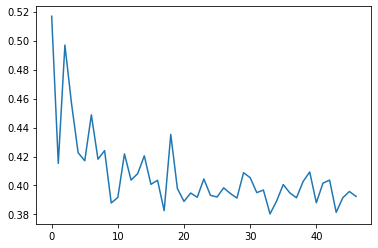

In [10]:
plt.plot(disc_losses['train'])

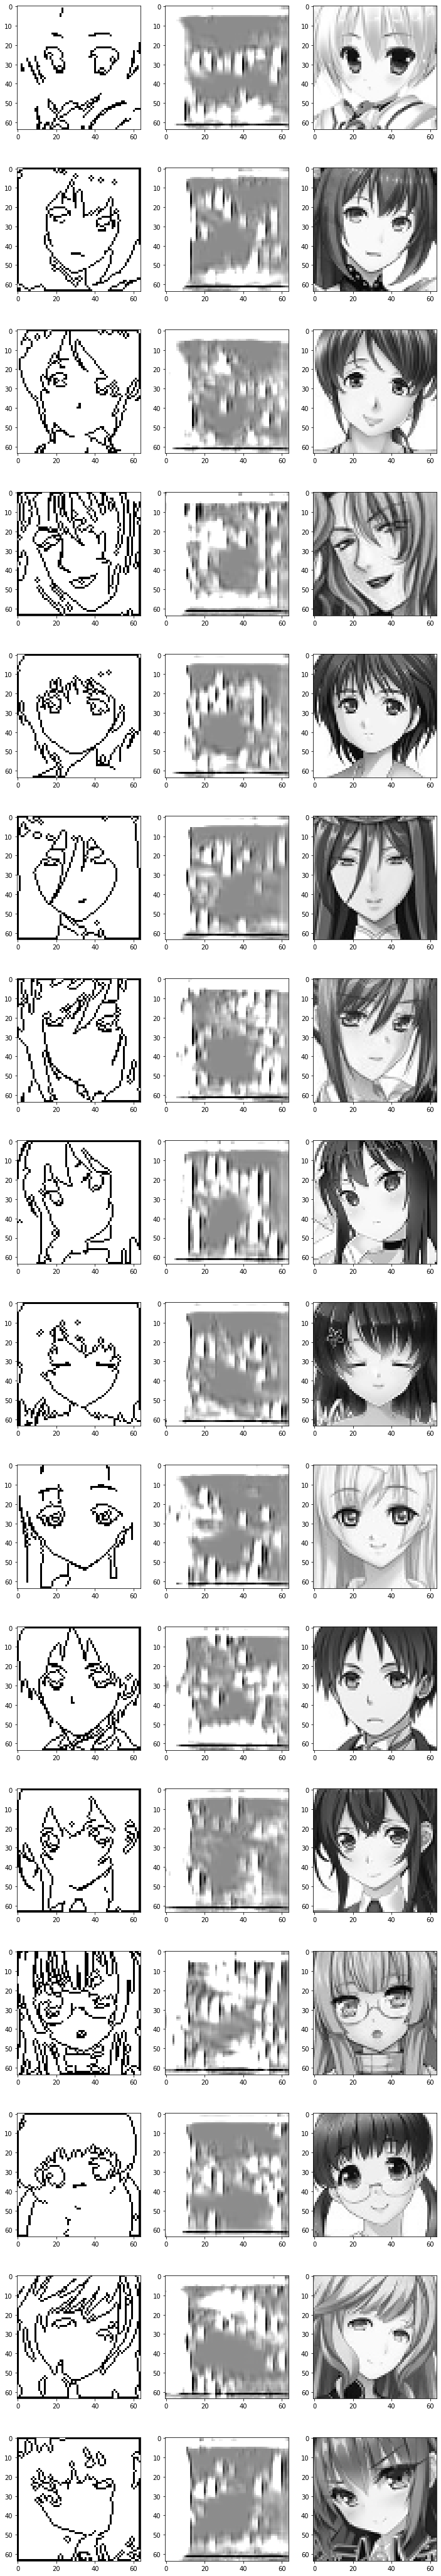

In [18]:
example_imgs = img_hist[46]

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')

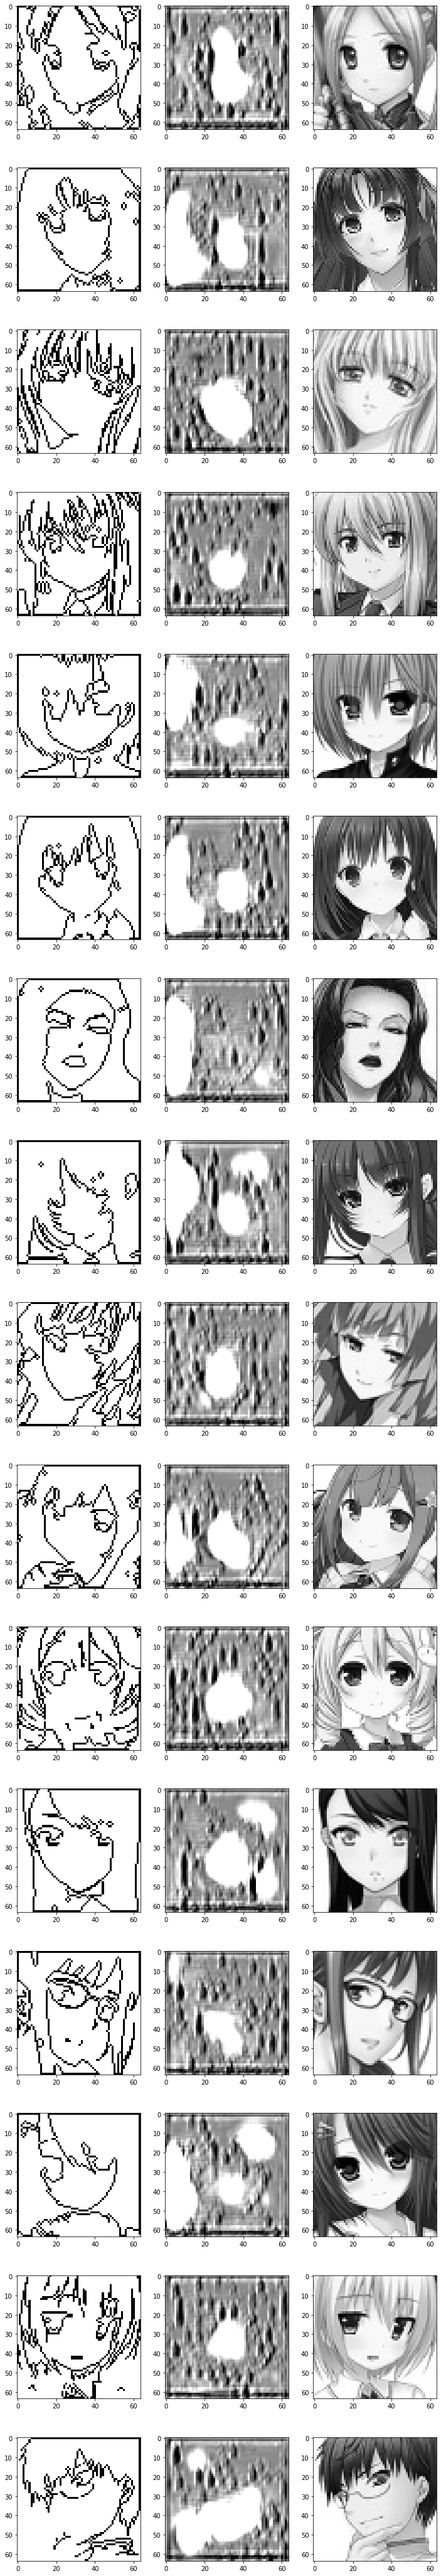

In [19]:
data_gen = get_generator('test')
example_imgs = gen_imgs(generator, next(data_gen))

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')